In [1]:
# Install required packages if needed
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow networkx

# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")
print("✅ All libraries imported successfully!")




Defaulting to user installation because normal site-packages is not writeable
✅ All libraries imported successfully!


In [2]:
#load the datset 
import pandas as pd
df = pd.read_csv("CloudWatch_Traffic_Web_Attack.csv")
# Preview the first 5 rows
df.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# 1. Load the dataset
df = pd.read_csv("CloudWatch_Traffic_Web_Attack.csv")
print("Data loaded successfully.")
print("First 5 rows:\n", df.head())
print("Data types:\n", df.dtypes)

# 2. Check for missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

# 3. Handle missing values
if 'bytes_in' in df.columns:
    df['bytes_in'] = df['bytes_in'].fillna(df['bytes_in'].median())

# Drop rows where critical IP fields are missing
for col in ['src_ip', 'dst_ip']:
    if col in df.columns:
        df.dropna(subset=[col], inplace=True)

# 4. Convert timestamp columns to datetime
for time_col in ['creation_time', 'end_time']:
    if time_col in df.columns:
        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')

# Optional: Extract time-based features
if 'creation_time' in df.columns:
    df['hour'] = df['creation_time'].dt.hour
    df['dayofweek'] = df['creation_time'].dt.dayofweek
    df.drop(columns=['creation_time', 'end_time'], inplace=True, errors='ignore')

# 5. Label encode categorical columns (adjust as needed)
label_cols = ['rule_names', 'src_ip', 'dst_ip']  
for col in label_cols:
    if col in df.columns:
        df[col] = LabelEncoder().fit_transform(df[col])
        print(f"Encoded column: {col}")
    else:
        print(f"Column not found: {col}")

# 6. Define features and target
if 'rule_names' in df.columns:
    X = df.drop('rule_names', axis=1)
    y = df['rule_names']
else:
    print("'rule_names' column not found.")
    X = df.copy()
    y = None

# 7. Keep only numeric features
X = X.select_dtypes(include=['int64', 'float64'])
print("Numeric features selected:\n", X.head())

# 8. Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features scaled. Shape:", X_scaled.shape)

# 9. Train-test split
if y is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    print("Train-test split completed.")
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_test shape:", y_test.shape)
else:
    print("⚠️ Target variable not defined. Skipping train-test split.")


Data loaded successfully.
First 5 rows:
    bytes_in  bytes_out         creation_time              end_time  \
0      5602      12990  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
1     30912      18186  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
2     28506      13468  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
3     30546      14278  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
4      6526      13892  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   

            src_ip src_ip_country_code protocol  response.code  dst_port  \
0   147.161.161.82                  AE    HTTPS            200       443   
1     165.225.33.6                  US    HTTPS            200       443   
2  165.225.212.255                  CA    HTTPS            200       443   
3   136.226.64.114                  US    HTTPS            200       443   
4   165.225.240.79                  NL    HTTPS            200       443   

         dst_ip              rule_names                      observation_name  \


In [4]:
#Anomaly Detection 
from sklearn.ensemble import IsolationForest
import numpy as np

# Step 1: Create the Isolation Forest model
iso = IsolationForest(
    n_estimators=100,        # Number of trees in the forest
    contamination=0.1,       # Approximate percentage of outliers in the data
    random_state=42          # For reproducibility
)

# Step 2: Fit the model and predict anomalies
anomaly_predictions = iso.fit_predict(X)

# Step 3: Convert prediction to binary anomaly label
# IsolationForest returns -1 for anomalies, 1 for normal
df['anomaly'] = np.where(anomaly_predictions == -1, 1, 0)
# Display anomaly counts clearly
summary = df['anomaly'].value_counts().rename(index={0: 'Normal', 1: 'Anomaly'})
print("Anomaly Count Summary:")
print(summary)


Anomaly Count Summary:
anomaly
Normal     253
Anomaly     29
Name: count, dtype: int64


Random Forest Accuracy: 1.0

 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        57

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57



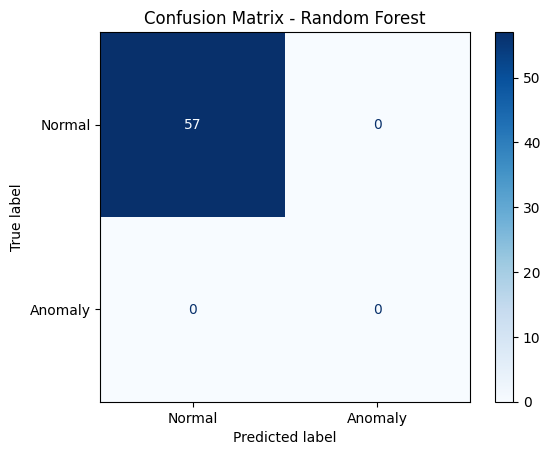

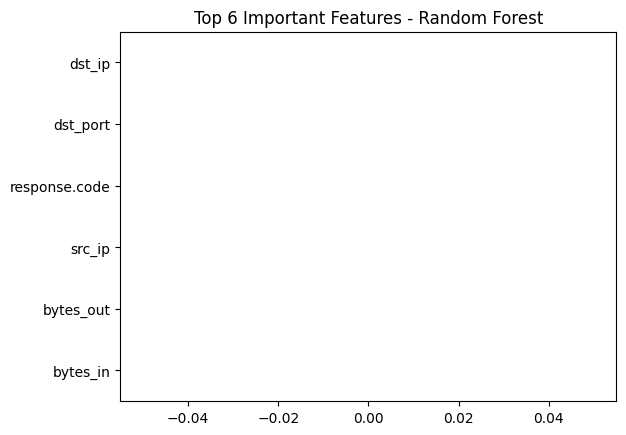

In [5]:
#Random Forest Classifier & Feature impoertance Plots
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# Encode labels
le = LabelEncoder()
y_train_labels = le.fit_transform(y_train)
y_test_labels = le.transform(y_test)

# Train the classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train_labels)

# Predict
y_pred_rf = rf.predict(X_test)
target_names = [str(cls) for cls in le.classes_]

# Evaluation
print("Random Forest Accuracy:", accuracy_score(y_test_labels, y_pred_rf))
print("\n Classification Report:\n", classification_report(y_test_labels, y_pred_rf, target_names=target_names))
labels = [0, 1]  # Adjust based on your encoding
cm = confusion_matrix(y_test_labels, y_pred_rf, labels=labels)
target_names = ['Normal', 'Anomaly']  # Make sure there are TWO labels

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.show()
# Get feature importance from RF
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.title("Top 6 Important Features - Random Forest")
plt.show()





Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.1722 - loss: 1.9829 - val_accuracy: 0.1333 - val_loss: 2.0199
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2722 - loss: 1.9516 - val_accuracy: 0.1333 - val_loss: 1.9590
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3111 - loss: 1.9066 - val_accuracy: 0.1778 - val_loss: 1.9010
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3222 - loss: 1.8744 - val_accuracy: 0.2667 - val_loss: 1.8495
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3833 - loss: 1.8229 - val_accuracy: 0.2444 - val_loss: 1.8001
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3944 - loss: 1.7979 - val_accuracy: 0.3333 - val_loss: 1.7597
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4278 - loss: 1.7587 - val_accuracy: 0.3778 - val_loss: 1.7260
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4333 - loss: 1.7265 - val_accuracy: 0.3778 - val_loss: 1.6988


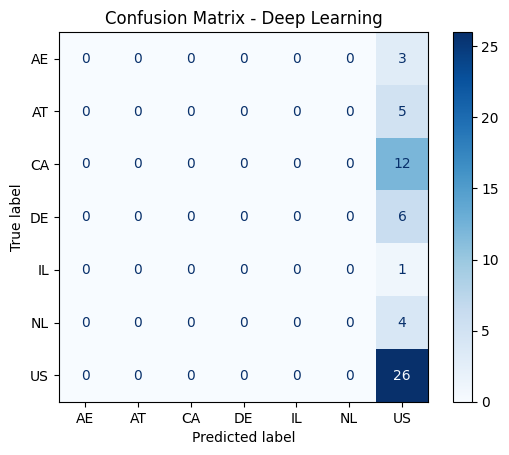

In [6]:
# STEP 1: Import Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# STEP 2: Load Dataset
df = pd.read_csv("CloudWatch_Traffic_Web_Attack.csv")

# STEP 3: Drop missing values
df.dropna(inplace=True)

# STEP 4: Separate features and target
X = df.drop(columns=(['creation_time', 'end_time', 'src_ip', 'src_ip_country_code',
       'protocol', 'dst_ip', 'rule_names', 'observation_name', 'source.meta',
       'source.name', 'time', 'detection_types'])# Also drop the target column from features
)

y = df['src_ip_country_code']               # Target

# STEP 5: Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)   # Encode strings into integers

# STEP 6: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# STEP 7: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# STEP 8: Build deep learning model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))  # Multi-class

# STEP 9: Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# STEP 10: Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# STEP 11: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\n Deep Learning Accuracy: {accuracy:.4f}")

# STEP 12: Predictions and Report
y_pred = np.argmax(model.predict(X_test), axis=1)

print("\n Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# STEP 13: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Deep Learning")
plt.show()


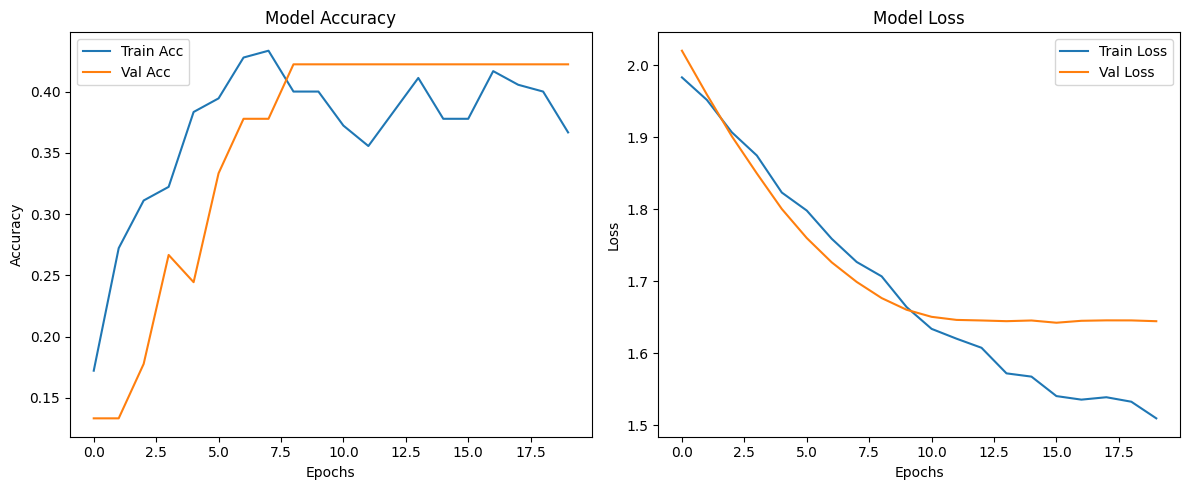

In [7]:
#Visualization of DL Accuracy & Loss
plt.figure(figsize=(12, 5))
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


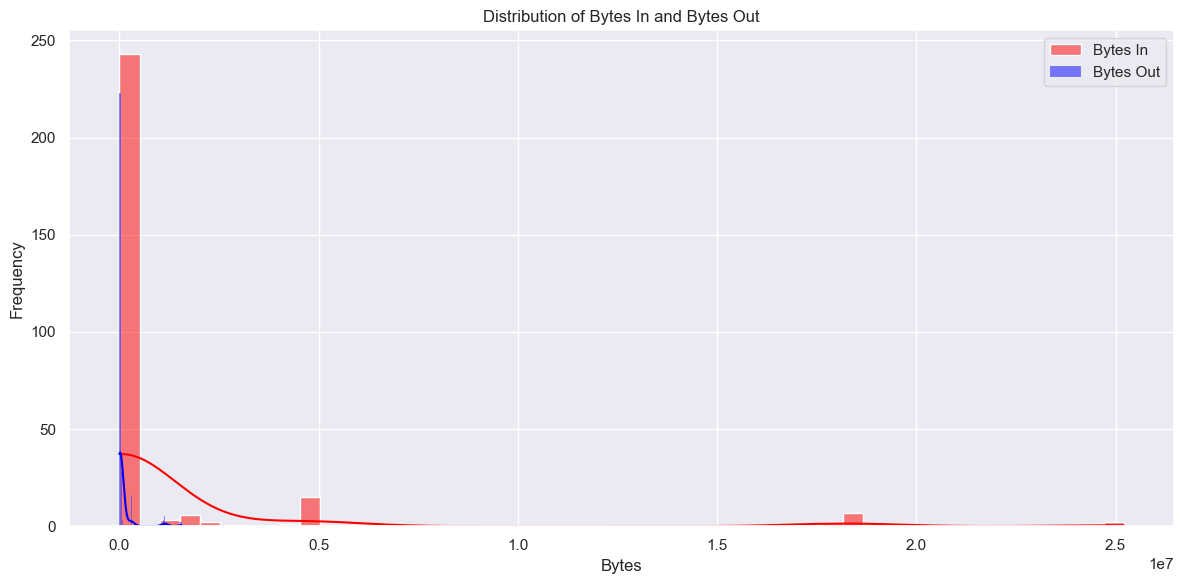

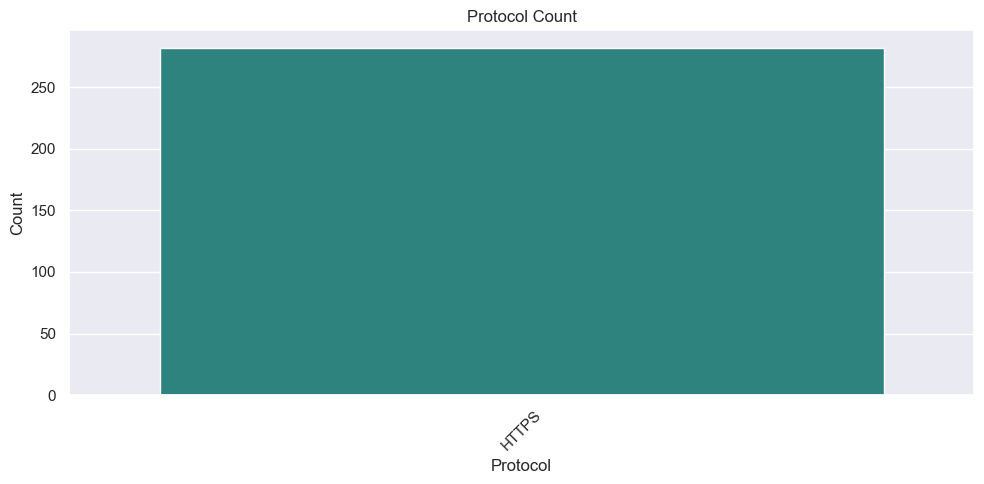

In [8]:
#visualization and EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Set theme for consistency
sns.set(style="darkgrid")

#  Distribution Plot of Bytes In and Bytes Out
plt.figure(figsize=(12, 6))
sns.histplot(df['bytes_in'], bins=50, color='red', kde=True, label='Bytes In')
sns.histplot(df['bytes_out'], bins=50, color='blue', kde=True, label='Bytes Out')
plt.legend()
plt.title('Distribution of Bytes In and Bytes Out')
plt.xlabel('Bytes')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 5))
sns.countplot(x='protocol', data=df, palette='viridis')
plt.title('Protocol Count')
plt.xlabel('Protocol')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

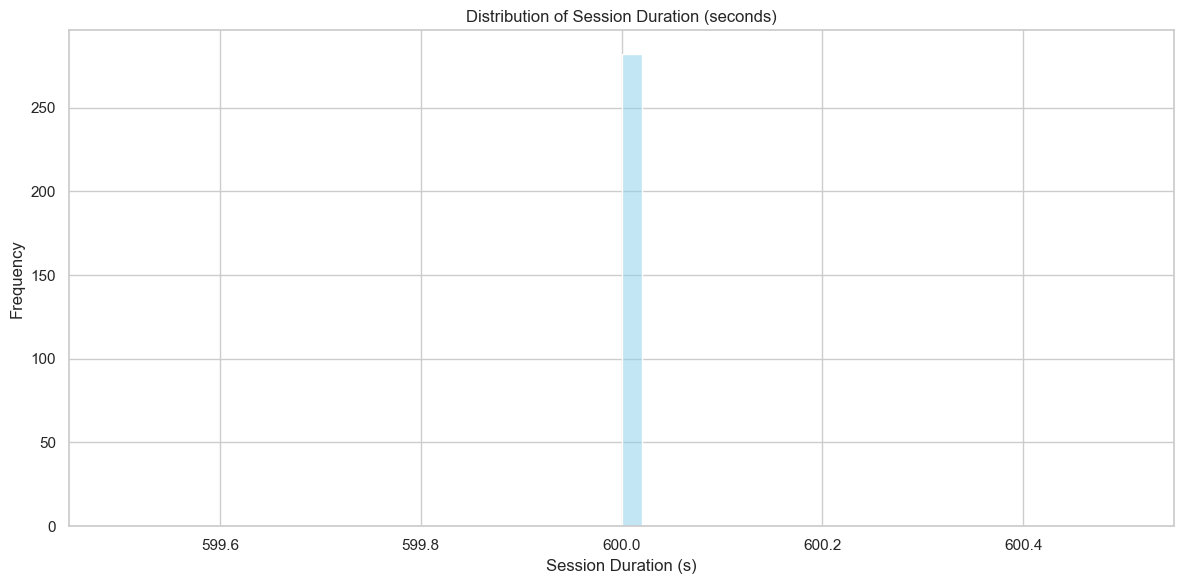

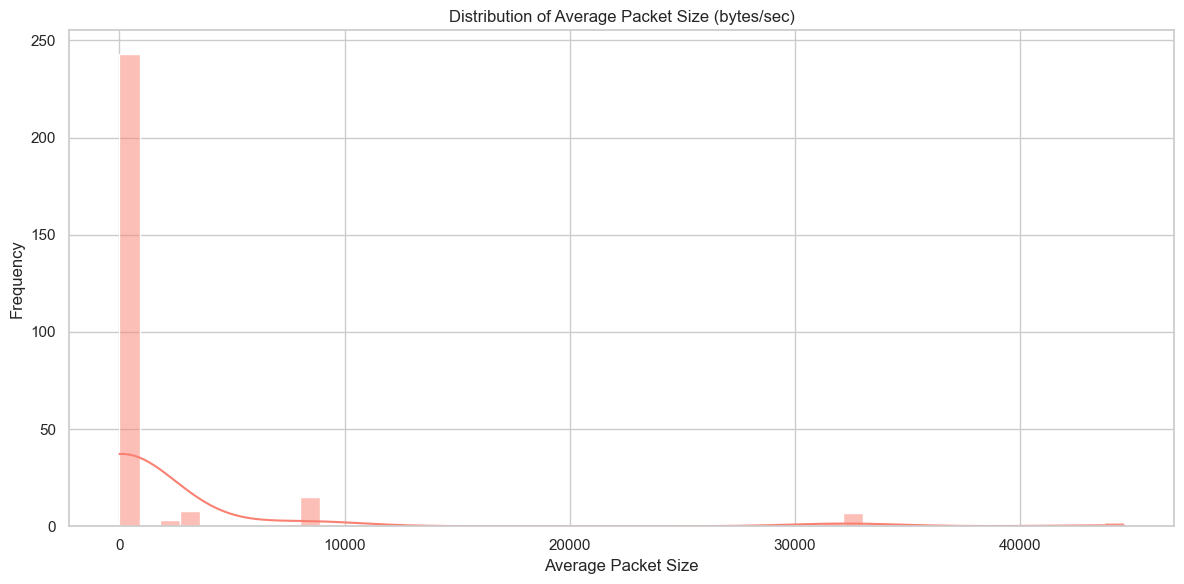

In [9]:
#feature Engineering
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Ensure datetime conversion
df['creation_time'] = pd.to_datetime(df['creation_time'], errors='coerce')
df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce')
df = df.dropna(subset=['creation_time', 'end_time'])
df['session_duration'] = (df['end_time'] - df['creation_time']).dt.total_seconds()
df['session_duration'] = df['session_duration'].replace(0, pd.NA)
df = df[df['session_duration'] > 0]
df['avg_packet_size'] = (df['bytes_in'] + df['bytes_out']) / df['session_duration']
df.dropna(subset=['avg_packet_size'], inplace=True)
# Set consistent style
sns.set(style="whitegrid")
# Plot 1: Distribution of Session Duration
plt.figure(figsize=(12, 6))
sns.histplot(df['session_duration'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Session Duration (seconds)')
plt.xlabel('Session Duration (s)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Plot 2: Distribution of Average Packet Size
plt.figure(figsize=(12, 6))
sns.histplot(df['avg_packet_size'], bins=50, kde=True, color='salmon')
plt.title('Distribution of Average Packet Size (bytes/sec)')
plt.xlabel('Average Packet Size')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()



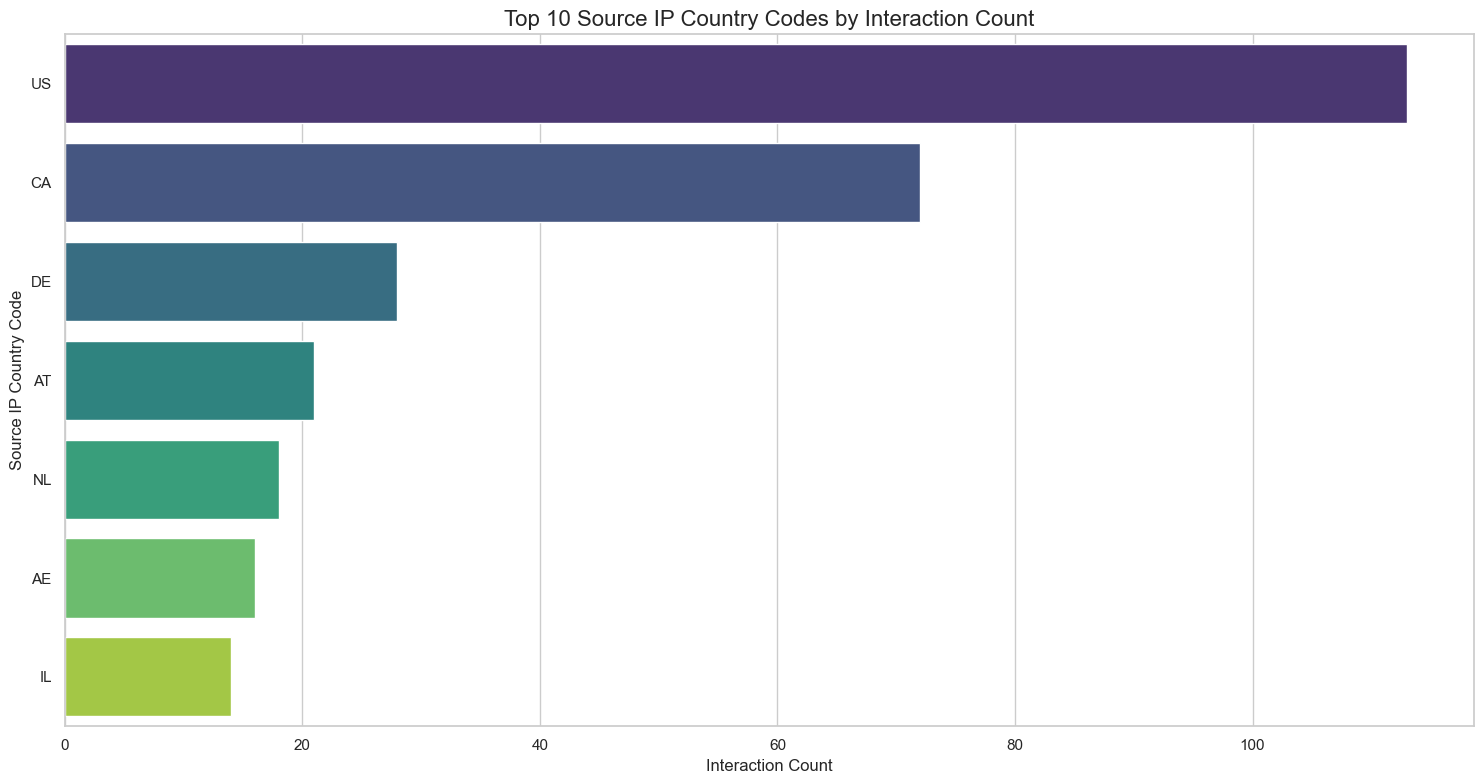

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv("CloudWatch_Traffic_Web_Attack.csv")

# Set style for better visuals
sns.set(style="whitegrid")

# ------------------------------
# Plot 1: Top 10 Interaction Count by Source IP Country Code
# ------------------------------
top_10_countries = df['src_ip_country_code'].value_counts().head(10).index

plt.figure(figsize=(15, 8))
sns.countplot(
    y='src_ip_country_code',
    data=df[df['src_ip_country_code'].isin(top_10_countries)],
    order=top_10_countries,
    palette='viridis'
)
plt.title('Top 10 Source IP Country Codes by Interaction Count', fontsize=16)
plt.xlabel('Interaction Count', fontsize=12)
plt.ylabel('Source IP Country Code', fontsize=12)
plt.tight_layout()
plt.show()



2025-08-08 21:31:52.159 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 21:31:52.160 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 21:31:53.999 
  command:

    streamlit run C:\Users\Lenovo\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-08-08 21:31:54.001 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 21:31:54.001 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 21:31:54.005 No runtime found, using MemoryCacheStorageManager
2025-08-08 21:31:54.007 No runtime found, using MemoryCacheStorageManager
2025-08-08 21:31:54.007 Thread 'MainThread': missing ScriptRunCont

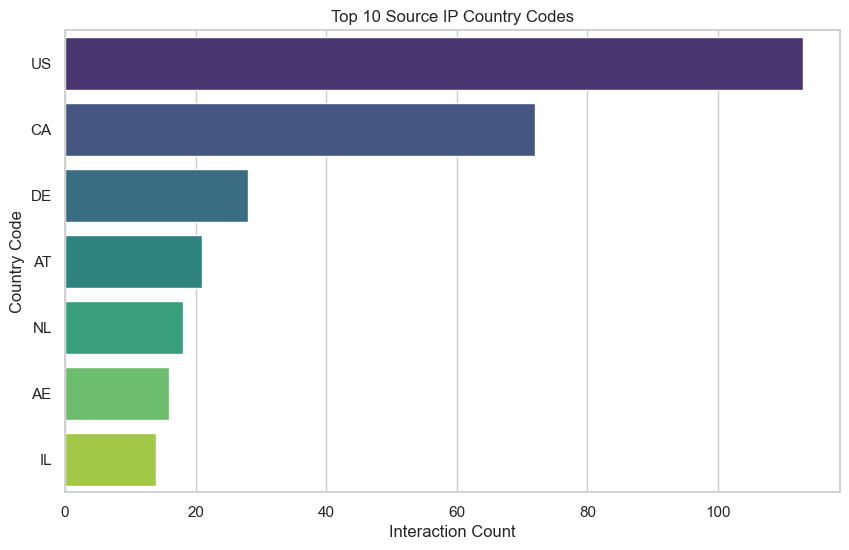

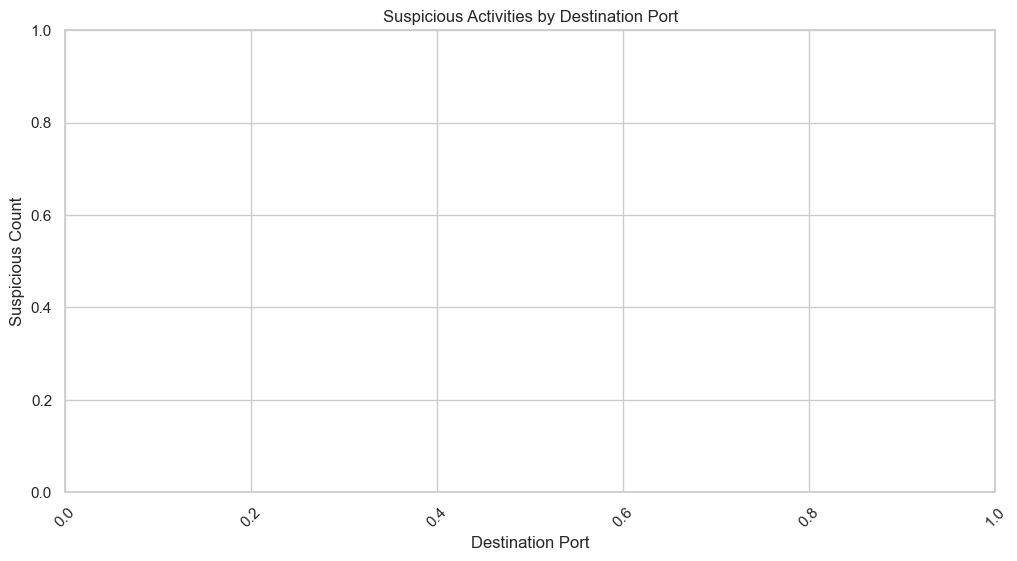

In [11]:
import streamlit as st
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set page config
st.set_page_config(page_title="Network Traffic Dashboard", layout="wide")

st.title("📊 Network Traffic Analysis Dashboard")

# Load data
@st.cache_data
def load_data():
    df = pd.read_csv("CloudWatch_Traffic_Web_Attack.csv")
    return df

df = load_data()

# Check columns
st.sidebar.title("🔍 Dataset Info")
if st.sidebar.checkbox("Show raw data"):
    st.write(df.head())

st.sidebar.subheader("Columns")
st.sidebar.write(df.columns.tolist())

# --- Plot 1: Top 10 Country Codes ---
st.subheader("🌍 Top 10 Source IP Country Codes")
if "src_ip_country_code" in df.columns:
    top_countries = df['src_ip_country_code'].value_counts().head(10).index
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    sns.countplot(
        y='src_ip_country_code',
        data=df[df['src_ip_country_code'].isin(top_countries)],
        order=top_countries,
        palette='viridis',
        ax=ax1
    )
    ax1.set_title("Top 10 Source IP Country Codes")
    ax1.set_xlabel("Interaction Count")
    ax1.set_ylabel("Country Code")
    st.pyplot(fig1)
else:
    st.warning("Column 'src_ip_country_code' not found in the dataset.")

# --- Plot 2: Suspicious Activities by Destination Port ---
st.subheader("🚨 Suspicious Activities by Destination Port")
if "detection_types" in df.columns and "dst_port" in df.columns:
    suspicious_df = df[df["detection_types"] == "Suspicious"]
    fig2, ax2 = plt.subplots(figsize=(12, 6))
    sns.countplot(
        x='dst_port',
        data=suspicious_df,
        order=suspicious_df['dst_port'].value_counts().index,
        palette='coolwarm',
        ax=ax2
    )
    ax2.set_title("Suspicious Activities by Destination Port")
    ax2.set_xlabel("Destination Port")
    ax2.set_ylabel("Suspicious Count")
    plt.xticks(rotation=45)
    st.pyplot(fig2)
else:
    st.warning("Columns 'detection_types' or 'dst_port' not found.")

# --- Plot 3: Anomaly Scatter Plot ---
st.subheader("📈 Bytes In vs Bytes Out with Anomalies")

# Try to infer anomaly column
anomaly_col = None
for col in df.columns:
    if 'anomaly' in col.lower():
        anomaly_col = col
        break

if anomaly_col and "bytes_in" in df.columns and "bytes_out" in df.columns:
    fig3, ax3 = plt.subplots(figsize=(10, 6))
    sns.scatterplot(
        x='bytes_in',
        y='bytes_out',
        hue=df[anomaly_col],
        data=df,
        palette={0: 'green', 1: 'red'},
        alpha=0.6,
        ax=ax3
    )
    ax3.set_title("Anomalies in Bytes In vs Bytes Out")
    ax3.set_xlabel("Bytes In")
    ax3.set_ylabel("Bytes Out")
    st.pyplot(fig3)
else:
    st.warning("Could not find columns for bytes or anomaly detection.")



In [12]:
pip install streamlit

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install jupytext


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
